In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM  # Updated import paths
from tensorflow.keras.models import Sequential

import tensorflow as tf

from itertools import cycle

plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings("ignore")



In [89]:
df = pd.read_csv('../data/returns_svi_edgar.csv')
df = df[['symbol', 'date', 'svi.1', 'edgar', 'price', 'volume', 'WeeklyReturns']]
df.rename(columns = {'svi.1':'svi'}, inplace=True)
df.head()

,symbol,date,svi,edgar,price,volume,WeeklyReturns
0,MSFT,2005-01-02,31338,145,26.67,398924026.0,NaN
1,MSFT,2005-01-09,33079,3220,26.12,379712121.0,-2.062242
2,MSFT,2005-01-16,20892,3030,25.65,266617523.0,-1.799387
3,MSFT,2005-01-23,34820,3539,26.18,409844550.0,2.066277
4,MSFT,2005-01-30,26115,4112,26.32,347830186.0,0.534759


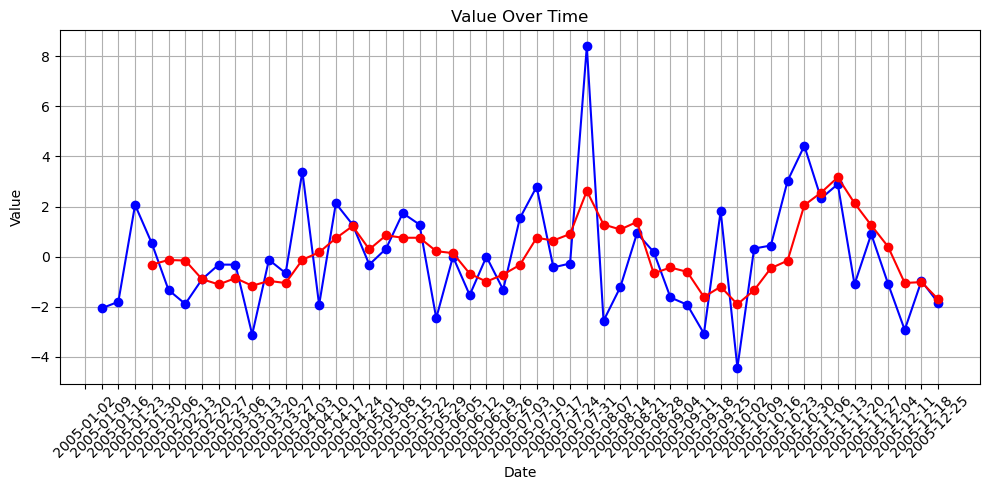

In [4]:
df_plot = df.loc[(df['symbol'] == 'MSFT')][0:52]
# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(df_plot['date'], df_plot['WeeklyReturns'], marker='o', linestyle='-', color='blue')  # Plot the data
plt.plot(df_plot['date'], df_plot['sma_4'], marker='o', linestyle='-', color='red')  # Plot the data
plt.title('Value Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

# Show the plot
plt.show()

In [90]:
def lagger(df, col,num):
    df[col +f'-shifted-({num})']  = df[col].shift(num)
    return df

def ticker_initialization(symbol, lag, sma_num):
     window_size = sma_num  # Number of periods for the SMA
     df_symbol = df.loc[df['symbol'] == symbol]
     df_symbol[f'sma-{sma_num}'] = df_symbol['WeeklyReturns'].rolling(window=window_size).mean()

     df_symbol = lagger(df_symbol, f'sma-{sma_num}', -lag)
     
     start = sma_num - lag
     end = len(df_symbol) - lag
     df_symbol = df_symbol[start:end]
     df_symbol.reset_index(inplace = True)

     return df_symbol


x = ticker_initialization('MSFT', 1, 4)


In [91]:
x

,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,sma-4,sma-4-shifted-(-1)
0,3,MSFT,2005-01-23,34820,3539,26.18000,409844550.0,2.066277,NaN,-0.315148
1,4,MSFT,2005-01-30,26115,4112,26.32000,347830186.0,0.534759,-0.315148,-0.132035
2,5,MSFT,2005-02-06,27856,3502,25.97000,360145305.0,-1.329787,-0.132035,-0.153886
3,6,MSFT,2005-02-13,34820,9272,25.48000,348529709.0,-1.886792,-0.153886,-0.896122
4,7,MSFT,2005-02-20,27856,4104,25.25000,329158361.0,-0.902669,-0.896122,-1.109020
...,...,...,...,...,...,...,...,...,...,...
953,956,MSFT,2023-04-30,84150,303573,310.64999,120572962.0,1.103294,1.655465,1.988372
954,957,MSFT,2023-05-07,76725,319867,308.97000,124127971.0,-0.540798,1.988372,2.779737
955,958,MSFT,2023-05-14,86625,139688,318.34000,121110679.0,3.032657,2.779737,2.041435
956,959,MSFT,2023-05-21,101475,364751,332.89001,158121682.0,4.570588,2.041435,1.954111


In [92]:
def standardize(column):
    mean_value = column.mean()
    std_dev = column.std()
    scaled_column = (column - mean_value) / std_dev
    return scaled_column

In [97]:
from sklearn.preprocessing import MinMaxScaler

def minmax(col):
     # Assuming 'your_column' is the column you want to normalize
     scaler = MinMaxScaler()
     # Reshape data for the scaler (it expects 2D array)
     column_reshaped = col.values.reshape(-1, 1)
     # Fit and transform the data
     minmax_col = scaler.fit_transform(column_reshaped)
     return minmax_col

In [96]:
df_total = pd.read_csv('../data/new_dataset.csv')
df = df_total
len(df)

278980

In [99]:
# creating batches and test, train size
Xs, ys = [], []
for t in df['symbol'].unique():
     x = ticker_initialization(t , 1, 4)
     x['input-1'] = minmax(standardize(x['svi']))
     x['input-2'] = minmax(standardize(x['edgar']))
     x['output'] = minmax(standardize(x['sma-4-shifted-(-1)']))

     X = x[['input-1', 'input-2']]
     y = x['output']
     time_steps = 4
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    if np.any(x_array == 0).sum() == 0:
                         Xs.append(x_array)
                         ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

print(X_train.shape, y_train.shape)

(141660, 4, 2) (141660,)


Epoch 1/50
2214/2214 [==============================] - 20s 7ms/step - loss: 0.0237 - mae: 0.1172 - val_loss: 0.0202 - val_mae: 0.1072
Epoch 2/50
2214/2214 [==============================] - 16s 7ms/step - loss: 0.0203 - mae: 0.1092 - val_loss: 0.0201 - val_mae: 0.1069
Epoch 3/50
2214/2214 [==============================] - 16s 7ms/step - loss: 0.0203 - mae: 0.1091 - val_loss: 0.0202 - val_mae: 0.1070
Epoch 4/50
2214/2214 [==============================] - 17s 8ms/step - loss: 0.0202 - mae: 0.1090 - val_loss: 0.0201 - val_mae: 0.1069
Epoch 5/50
2214/2214 [==============================] - 17s 8ms/step - loss: 0.0200 - mae: 0.1084 - val_loss: 0.0200 - val_mae: 0.1062
Epoch 6/50
2214/2214 [==============================] - 16s 7ms/step - loss: 0.0200 - mae: 0.1083 - val_loss: 0.0201 - val_mae: 0.1067
Epoch 7/50
2214/2214 [==============================] - 16s 7ms/step - loss: 0.0199 - mae: 0.1081 - val_loss: 0.0200 - val_mae: 0.1059
Epoch 8/50
2214/2214 [==============================] -

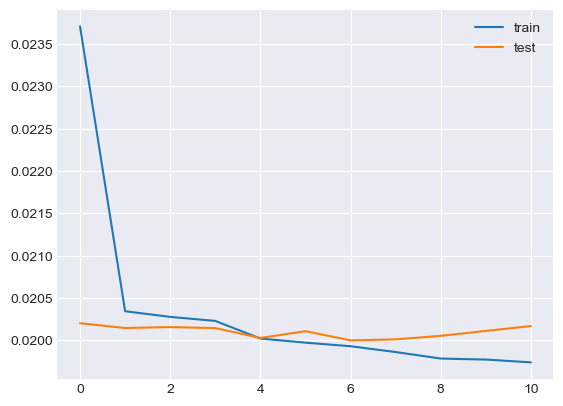

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# number_of_features is the number of features in your input data
number_of_features = X.shape[1]

model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(4, number_of_features)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False, 
                    callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [101]:
y_pred = model.predict(X_test, verbose=1)



1107/1107 [==============================] - 4s 3ms/step


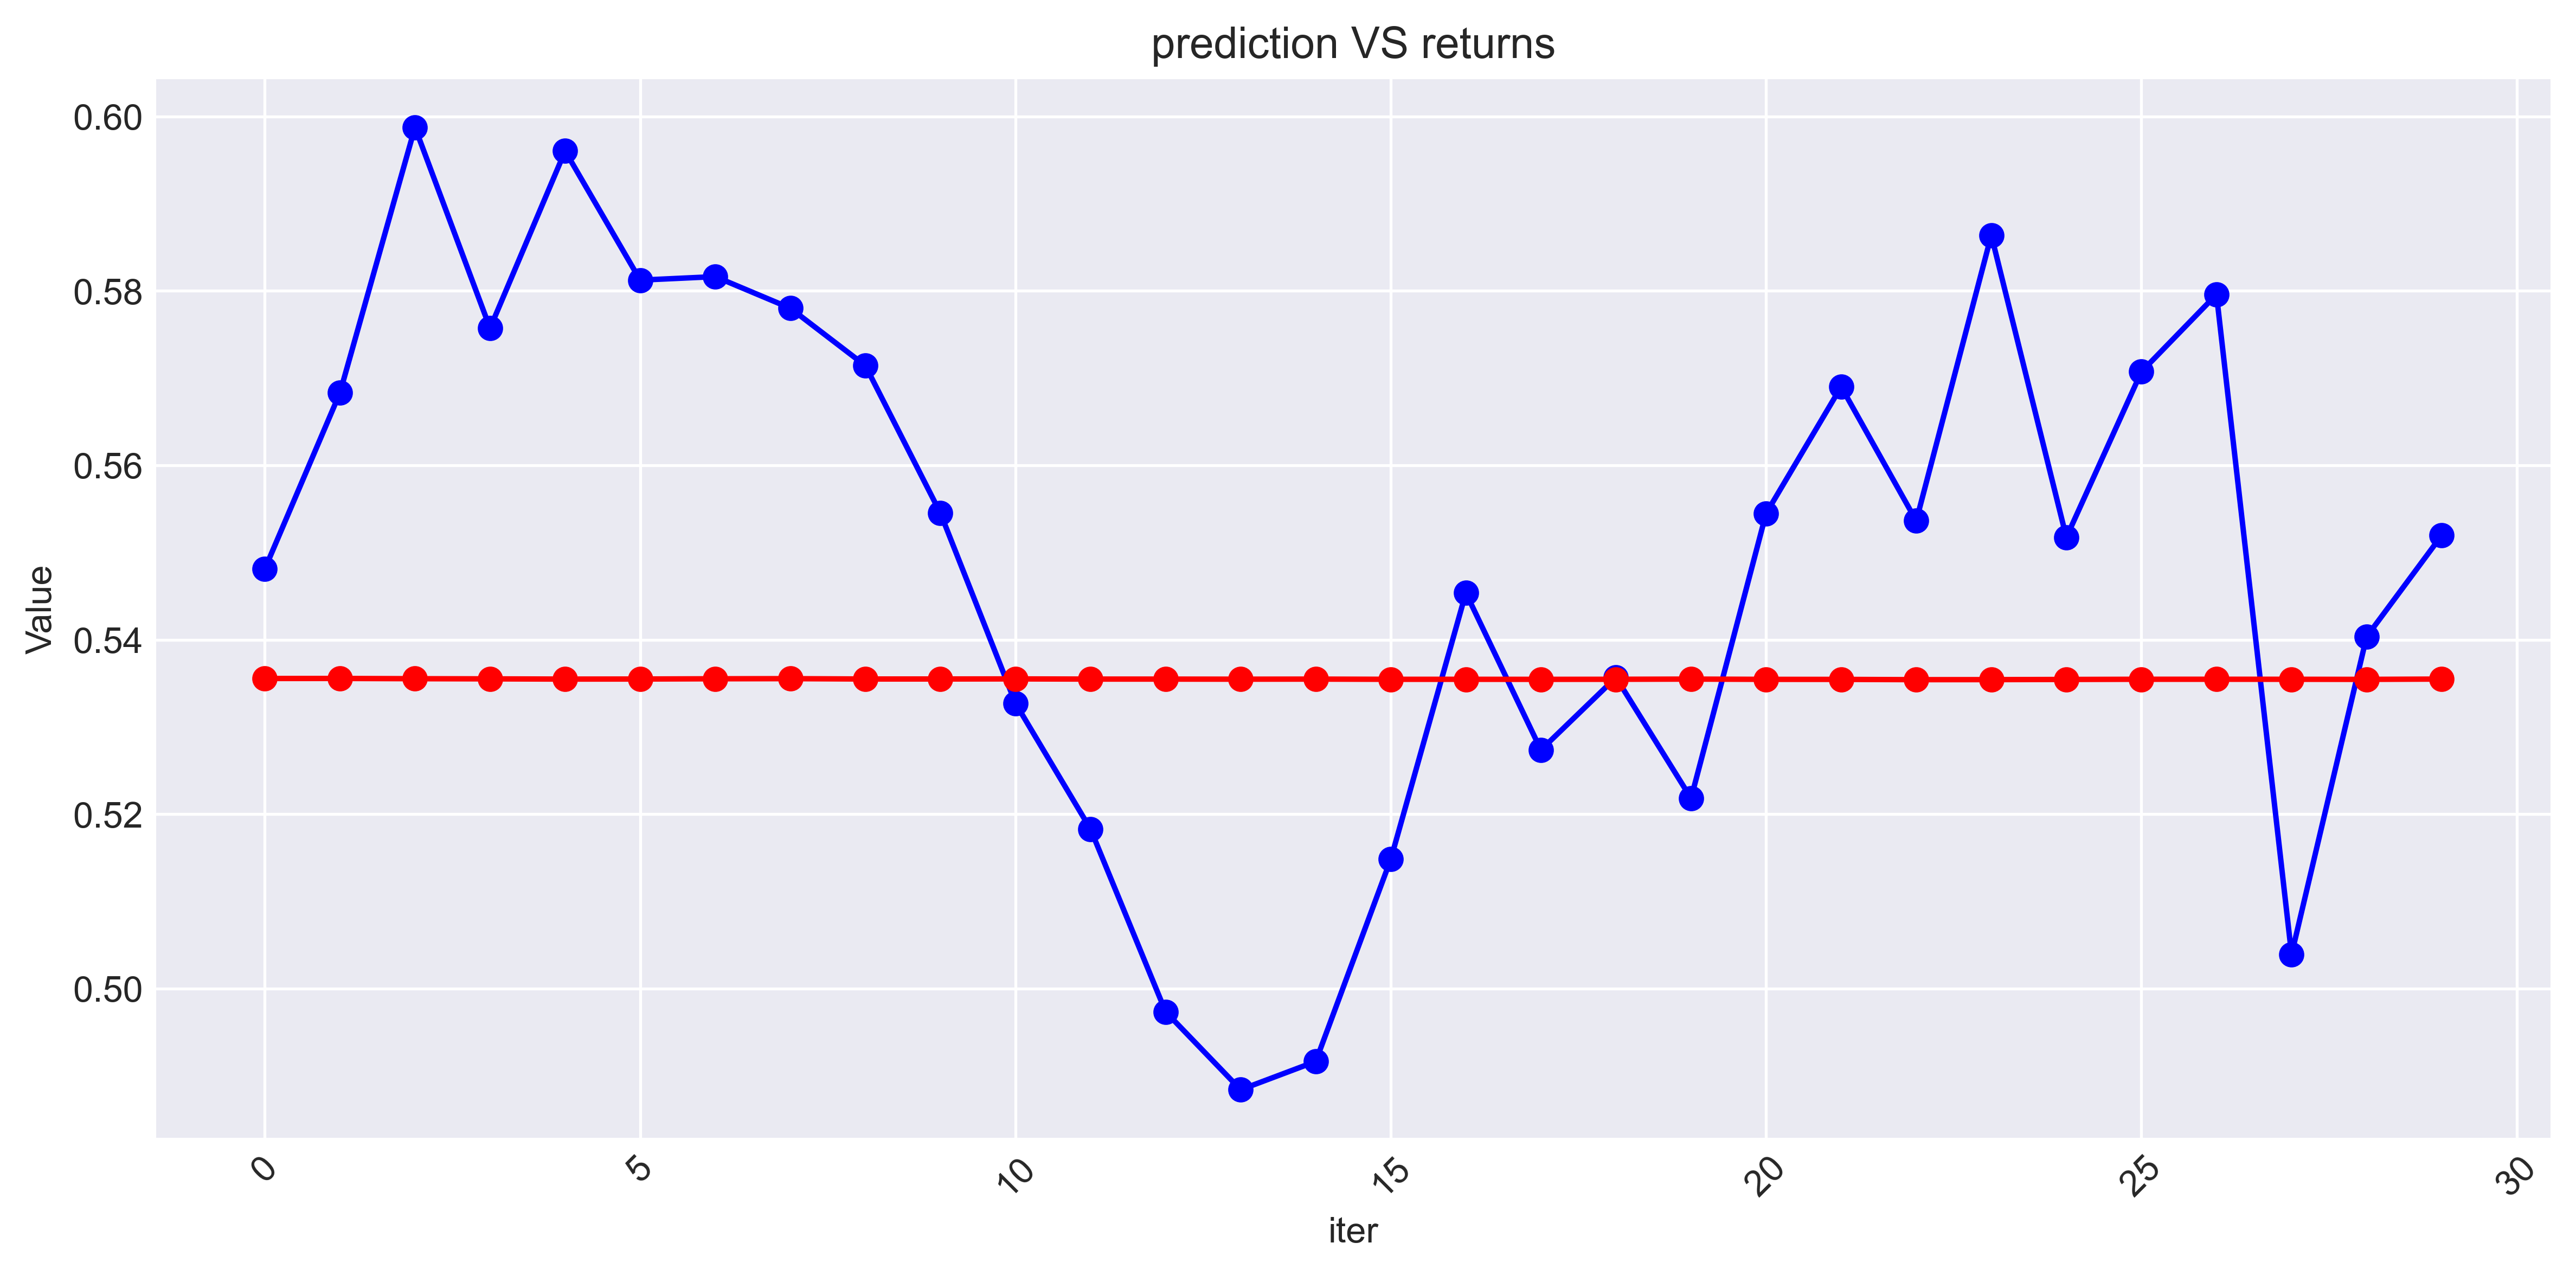

In [104]:
plt.figure(figsize=(10, 5), dpi=480)  # Set the figure size (optional)
plt.plot(y_test[0:30], marker='o', linestyle='-', color='blue')  # Plot the data
plt.plot(y_pred[0:30], marker='o', linestyle='-', color='red')  # Plot the data
plt.title('prediction VS returns')  # Title of the plot
plt.xlabel('iter')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

# Show the plot
plt.show()

In [82]:
model.save('LSTM-Regression.h5')

### End of Notebook